In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import text_preprocessing as tp

from multiprocessing import Pool
from multiprocessing import cpu_count

import codecs
import json
import os
import csv

import pickle

/Users/sudevchirappat/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Collect and Pre-processing training data

Training data sourced from here : 
https://www.kaggle.com/rmisra/news-category-dataset

In [2]:
df_kaggle = pd.read_json('Data/Training_Data/News_Category_Dataset_v2.json',lines=True)

In [3]:
df_kaggle.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
relabel = {
    "POLITICS"	: "Society",
"WELLNESS": "Other",
"ENTERTAINMENT" :	"Entertainment",
"TRAVEL"	: "Other",
"STYLE & BEAUTY"	: "Entertainment",
"PARENTING":	"Other",
"HEALTHY LIVING"	: "Other",
"QUEER VOICES"	: "Society",
"FOOD & DRINK"	: "Other",
"BUSINESS"	: "Economy",
"COMEDY"	: "Entertainment",
"SPORTS"	: "Sports",
"BLACK VOICES":	"Society",
"HOME & LIVING"	: "Other",
"PARENTS"	: "Other",
"THE WORLDPOST"	:"Society",
"WEDDINGS"	:"Other",
"WOMEN"	:"Other",
"IMPACT"	:"Society",
"DIVORCE" :	"Other",
"CRIME"	: "Society",
"MEDIA" :	"Entertainment",
"WEIRD NEWS"	: "Other",
"GREEN" :	"Society",
"WORLDPOST"	 : "Society",
"RELIGION"	: "Other",
"STYLE"	 : "Entertainment",
"SCIENCE"	: "Science",
"WORLD NEWS"	: "Society",
"TASTE"	:"Entertainment",
"TECH"	:"Technology",
"MONEY"	:"Economy",
"ARTS"	:"Entertainment",
"FIFTY"	:"Other",
"GOOD NEWS" :	"Other",
"ARTS & CULTURE"	:"Entertainment",
"ENVIRONMENT"	:"Society",
"COLLEGE"	:"Other",
"LATINO VOICES":	"Society",
"CULTURE & ARTS"	:"Entertainment",
"EDUCATION"	:"Science"
}

In [5]:
df_kaggle["category"].replace(relabel, inplace=True)

In [6]:
df_kaggle.head()

,category,headline,authors,link,short_description,date
0,Society,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,Entertainment,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,Entertainment,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,Entertainment,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,Entertainment,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [7]:
df_kaggle['all_text'] = df_kaggle['headline'] + "\n" + df_kaggle['short_description']

In [8]:
tp.preprocess(df_kaggle['all_text'][0])

['two',
 'mass',
 'shootings',
 'texas',
 'last',
 'week',
 'one',
 'tv',
 'left',
 'husband',
 'killed',
 'children',
 'another',
 'day',
 'america']

In [9]:
%%time
with Pool(cpu_count()) as pool:
    results = pool.map(tp.preprocess, list(df_kaggle.all_text))

CPU times: user 1.46 s, sys: 439 ms, total: 1.9 s
Wall time: 3min 48s


In [10]:
kaggle_dataset = []
i = 0
for r in results:
    d = {'label':df_kaggle.category[i],
        'tokens':r,
        'url':df_kaggle.link[i],
        'date':df_kaggle.date[i]}
    i = i+1
    kaggle_dataset.append(d)

In [11]:
# Save to pickle
with open('Data/kaggle_dataset.pickle',"wb") as p:
    pickle.dump(kaggle_dataset,p)

In [12]:
# Load from pickle
with open('Data/kaggle_dataset.pickle','rb') as p:
    kaggle_dict = pickle.load(p)

In [13]:
df = pd.DataFrame(kaggle_dict)

In [14]:
df.head()

,label,tokens,url,date
0,Society,"[two, mass, shootings, texas, last, week, one,...",https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26
1,Entertainment,"[smith, joins, diplo, nicky, jam, two thousand...",https://www.huffingtonpost.com/entry/will-smit...,2018-05-26
2,Entertainment,"[hugh, grant, marries, first, time, age, fifty...",https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26
3,Entertainment,"[jim, carrey, blasts, castrato, adam, schiff, ...",https://www.huffingtonpost.com/entry/jim-carre...,2018-05-26
4,Entertainment,"[julianna, margulies, uses, donald, trump, poo...",https://www.huffingtonpost.com/entry/julianna-...,2018-05-26


In [15]:
def load_vectors(fname):
    import io
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return n,d,data


In [16]:
%%time
n,d,ft_dict = load_vectors("assets/wiki-news-300d-1M.vec")

CPU times: user 1min 3s, sys: 21.8 s, total: 1min 25s
Wall time: 1min 28s


In [17]:
def get_ft_vec(token,ft_dict,d=300):
    try:
        v = np.array(ft_dict[token])
    except KeyError:
        v = np.array([0]*d)
    return v

In [18]:
def compute_ft_sum(textlist,ft_dict=None,d=300,**kwargs):
    '''ft_dict should be loaded to memory before-hand!
    If ft_dict is not passed as it is, the relative path
    of the vector has to be provided in the argument 
    'vec_loc'
    TODO : Need better implemenation of this.
    '''
    
    if not ft_dict:
        try:
            # Load the FastText vector. MUST IMPROVE SPEEDS
            from time import time
            t_start = time()
            _,_,ft_dict = load_vectors(EN_VEC)
            logger.info(f"FT_Vector loaded in {time()-t_start} seconds")
        except FileNotFoundError as e:
            logger.error("Vector not found")
    
    ret_vec = np.array([0]*d)
    for key in textlist:
        vec = get_ft_vec(key,ft_dict)
        # Vector addition of token embeddings
        ret_vec = ret_vec + vec
    # Now that tokens are all added up,
    # divide by number of tokens to get
    # average weight
    ret_vec = ret_vec/len(textlist)
 
    return ret_vec

In [19]:
# This function is to convert the 300D vector 
# in to a unit vector.

def norm_to_unit_vector(df):
    sq = np.square(df.drop("label", axis=1))
    sqrrt = np.sqrt(sq.sum(axis=0))

    final = df.drop("label", axis=1).divide(sqrrt, axis=1)
    return final

In [20]:
%%time
'''
This could've been multiprocessed. But couldn't figure how to 
pass the ft_dict in the right fashion. FAILURE -_-
'''
vector = df.tokens.map(lambda x : compute_ft_sum(x,ft_dict=ft_dict))

/Users/sudevchirappat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 1min 40s, sys: 2.96 s, total: 1min 43s
Wall time: 1min 44s


In [21]:
%%time
df_vector = pd.DataFrame.from_items(zip(vector.index, vector.values)).T

/Users/sudevchirappat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


CPU times: user 10.8 s, sys: 22.2 s, total: 33 s
Wall time: 36.6 s


In [22]:
df_vector['label'] = df['label']

In [23]:
# Save to file
df_vector.to_csv("Data/Training_Data/df_kaggle_vector.csv",index=False)

In [24]:
# If normalization is required
# df_norm = norm_to_unit_vector(df_vector)

In [25]:
# Load from file
df = pd.read_csv('Data/Training_Data/df_kaggle_vector.csv')

In [26]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,label
0,0.033573,0.030120,-0.013333,-0.004280,-0.010280,-0.000020,0.046047,-0.003707,0.016067,0.000820,...,-0.039760,0.043267,0.032080,0.067747,-0.015733,-0.023620,0.070020,0.075827,0.017567,Society
1,-0.064742,0.023908,-0.004233,-0.030258,-0.014892,0.022708,0.041967,0.011658,0.009667,0.021217,...,-0.042900,-0.022133,0.021533,0.050833,-0.028792,0.011250,0.047133,-0.015700,-0.006367,Entertainment
2,0.066769,0.007206,-0.010712,-0.059450,-0.050756,0.013675,0.062431,-0.004919,-0.018869,0.041400,...,-0.010281,-0.030531,-0.009381,0.009750,0.042487,-0.039094,0.051881,0.023563,0.040287,Entertainment
3,-0.012333,-0.007461,-0.100556,0.020939,-0.002461,-0.000728,0.063122,-0.017244,0.030683,-0.013228,...,-0.060050,0.059711,0.038639,0.081500,0.024872,-0.025722,0.081683,-0.010978,-0.054689,Entertainment
4,-0.012261,0.044161,-0.020506,0.011789,-0.026433,-0.032822,0.030433,-0.011083,0.010517,0.012244,...,-0.014150,0.064528,0.039233,0.055917,0.017133,-0.027028,0.107417,-0.005850,-0.020822,Entertainment


In [27]:
df.shape

(200853, 301)

In [28]:
df.label.value_counts()

Other            77197
Society          63939
Entertainment    41925
Economy           7644
Sports            4884
Science           3182
Technology        2082
Name: label, dtype: int64

### Useful functions

In [29]:
def numerize_label(s):
    '''
    LightGBM accepts '''
    d = {'Society|Politics':0,
         'Economy|Finance' : 1,
         'Tech' : 2,
         'Sports' :3,
         'Entertainment' :4,
         'Science' :5,
         'Other' :6}
    return s.replace(d, regex=True).map(lambda x : int(x))
    

In [30]:
def labelize_numeric(arr):
    d = {0:'society',
         1:'economy',
         2:'technology',
         3:'sports',
         4:'entertainment',
         5:'science',
         6:'other'}
    
    return [d[k] for k in arr]

In [31]:
def setup_data_for_training(df,drop_cols = ['label']):
    # get the labels
    y = numerize_label(df['label'])
    
    x = df.drop(drop_cols, axis=1)

    #
    # Create training and validation sets
    #

    # x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    return train_data,val_data,test_data

### Convert the labels to numeric for LightGBM

In [32]:
y = numerize_label(df['label'])

### Set up train-val-test split

In [33]:
train_data,val_data,test_data = setup_data_for_training(df,['label'])

In [34]:
train_data.data.shape,val_data.data.shape,test_data.data.shape

((128545, 300), (32137, 300), (40171, 300))

### Set up lightGBM parameters and train the model.

Ideally, the hyper-parameters should be tuned using Optuna. But time constraints


In [35]:
#
# Train the model
#
parameters = {
          "objective" : "multiclass",
          "num_class" : 7,
          "num_leaves" : 60,
          "max_depth": -1,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 802,
          "verbosity" : -1 }

In [36]:
%%time
model = lgb.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[1]	valid_0's multi_logloss: 1.32748
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.27893
[3]	valid_0's multi_logloss: 1.23817
[4]	valid_0's multi_logloss: 1.2032
[5]	valid_0's multi_logloss: 1.17237
[6]	valid_0's multi_logloss: 1.14495
[7]	valid_0's multi_logloss: 1.12012
[8]	valid_0's multi_logloss: 1.09779
[9]	valid_0's multi_logloss: 1.07807
[10]	valid_0's multi_logloss: 1.06006
[11]	valid_0's multi_logloss: 1.04399
[12]	valid_0's multi_logloss: 1.02853
[13]	valid_0's multi_logloss: 1.01465
[14]	valid_0's multi_logloss: 1.0022
[15]	valid_0's multi_logloss: 0.989756
[16]	valid_0's multi_logloss: 0.978655
[17]	valid_0's multi_logloss: 0.968455
[18]	valid_0's multi_logloss: 0.9587
[19]	valid_0's multi_logloss: 0.949642
[20]	valid_0's multi_logloss: 0.941254
[21]	valid_0's multi_logloss: 0.933433
[22]	valid_0's multi_logloss: 0.925917
[23]	valid_0's multi_logloss: 0.918834
[24]	valid_0's multi_logloss: 0.912115
[25]	valid_0's multi_logloss:

In [37]:
m_name = 'assets/models/lgb_model_kaggle_data.txt'
model.save_model(m_name)

In [38]:
# %%time
# # load model to predict
# model = lgb.Booster(model_file=m_name)

In [39]:
%%time
y_pred = model.predict(test_data.data)

CPU times: user 11.7 s, sys: 481 ms, total: 12.1 s
Wall time: 2.92 s


In [40]:
max_p_index = np.argmax(y_pred,axis=1)

In [41]:
# Accuracy when most probable class is chosen as the label
(max_p_index == test_data.label).mean()

0.7464588882527197

In [42]:
# Function to predic thte label
def predict_label(df_test,model):
    '''Make the prediction using LightGBM prediction
    method. Return the class with maximum probability
    
    TODO : There should be better logic in choosing
    the final label'''
    # TODO : Implement other logic for the predction
    y_pred = model.predict(df_test)
    max_p_index = np.argmax(y_pred,axis=1)
    label = labelize_numeric(max_p_index)
    return label

In [43]:
y_pred = predict_label(test_data.data,model)

y_orig = labelize_numeric(test_data.label)

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    plt.figure(figsize=(7, 6), dpi= 80, facecolor='w', edgecolor='k')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_orig, y_pred)
np.set_printoptions(precision=2)

In [44]:
labelize_numeric(range(0,6))

['society', 'economy', 'technology', 'sports', 'entertainment', 'science']

### Confusion matrix to show where the model is going wrong

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

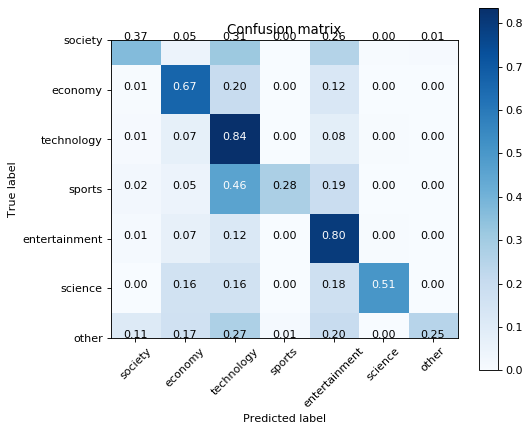

In [45]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelize_numeric(range(0,7)),normalize=True)